<a href="https://colab.research.google.com/github/Balbuenar/Unclassified--repo/blob/master/Petrol_Consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Petrol Consumption

Superviced Learning Linear Regression

---

---
*By Richard Balbuena*




## Data Description
For one year, the consumption of petrol was measured in 48 states. The relevant variables are the petrol tax, the per capita income, the number of miles of paved highway, and the proportion of the population with driver's licenses.
There are 7 columns and 48 rows of data.  The data include:
* I,  the index;
* A0, 1;
* A1, the petrol tax;
* A2, the per capita income;
* A3, the number of miles of paved highway;
* A4, the proportion of drivers;
* B,  the consumption of petrol.
As the first two columns in the above dataset do not provide any useful information, therefore we have to remove them from the dataset file in order to complete our analysis. 


Importing libreries

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline

Loading the dataset from my Google Drive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
dataset = pd.read_csv("/content/gdrive/MyDrive/petrol_consumption.csv")

Data exploration

In [4]:
dataset.dtypes.value_counts()

int64      3
float64    2
dtype: int64

In [5]:
dataset.shape

(48, 5)

There are 7 columns and 48 rows of data.

In [6]:
dataset.keys()

Index(['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)', 'Petrol_Consumption'],
      dtype='object')

The data include:
* Petro Tax
* Average Income
* Paved_Highways
* Population with Driver Licence
* Petrol Consumption

In [7]:
dataset.head()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
0,9.0,3571,1976,0.525,541
1,9.0,4092,1250,0.572,524
2,9.0,3865,1586,0.580,561
3,7.5,4870,2351,0.529,414
4,8.0,4399,431,0.544,410


In [8]:
dataset.describe()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%),Petrol_Consumption
count,48.000000,48.000000,48.000000,48.000000,48.000000
mean,7.668333,4241.833333,5565.416667,0.570333,576.770833
std,0.950770,573.623768,3491.507166,0.055470,111.885816
min,5.000000,3063.000000,431.000000,0.451000,344.000000
25%,7.000000,3739.000000,3110.250000,0.529750,509.500000
50%,7.500000,4298.000000,4735.500000,0.564500,568.500000
75%,8.125000,4578.750000,7156.000000,0.595250,632.750000
max,10.000000,5342.000000,17782.000000,0.724000,968.000000


Some statistical information of our data. 

# Determining Normality
Making our target variable normally distributed often will lead to better results

If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.

How can we tell if our target is normally distributed? There are two ways:

* Visually
* Using a statistical test
## Visually
Plotting a histogram:

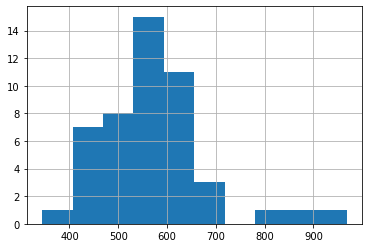

In [9]:
dataset.Petrol_Consumption.hist();

In [10]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

Without getting into Bayesian vs. frequentist debates, for the purposes of this lesson, the following will suffice:

This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say:
This test outputs a "p-value". The higher this p-value is the closer the distribution is to normal.
Frequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.

p-value extremely low. Our y variable we've been dealing with this whole time was not normally distributed!

Linear Regression assumes a normally distributed residuals which can be aided by transforming y variable. Let's try some common transformations to try and get y to be normally distributed:

Log
Square root
Box cox

## Box cox
The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible".

It is defined as:

boxcox(𝑦𝑖)=𝑦𝜆𝑖−1𝜆
 
You can think of as a generalization of the square root function: the square root function uses the exponent of 0.5, but box cox lets its exponent vary so it can find the best one.

In [11]:
from scipy.stats import boxcox

In [12]:
bc_result = boxcox(dataset.Petrol_Consumption)
boxcox_PC = bc_result[0]
lam = bc_result[1]

In [13]:
lam

-0.2631171067689914

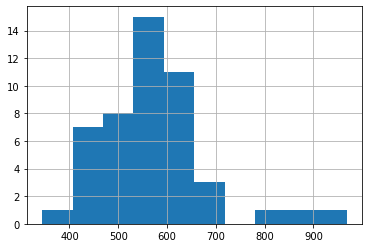

In [14]:
dataset['Petrol_Consumption'].hist();

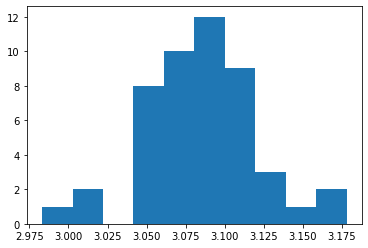

In [15]:
plt.hist(boxcox_PC);

In [16]:
normaltest(boxcox_PC)

NormaltestResult(statistic=2.696832387737183, pvalue=0.25965117227649476)

Now that we have a normally distributed y-variable, let's try a regression!

## Testing regression:

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, 
                                   PolynomialFeatures)

In [18]:
lr = LinearRegression()

## Creaste X and y

In [19]:
y_col = "Petrol_Consumption"

X = dataset.drop(y_col, axis=1)
y = dataset[y_col]

## Create Polynomial Features

In [20]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

### Train test split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

### Fit StandardScaler on X_train as before

In [22]:
s = StandardScaler()
X_train_s = s.fit_transform(X_train)

In [23]:
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

As before, we'll now:

1. Fit regression
2. Transform testing data
3. Predict on testing data

In [24]:
y_train_bc.shape

(33,)

In [25]:
lr.fit(X_train_s, y_train_bc)
X_test_s = s.transform(X_test)
y_pred_bc = lr.predict(X_test_s)

### Inverse transform
Every transformation has an inverse transformation. The inverse transformation of  𝑓(𝑥)=𝑥⎯⎯√  is  𝑓−1(𝑥)=𝑥2 , for example. Box cox has an inverse transformation as well: notice that we have to pass in the lambda value that we found from before:

In [26]:
from scipy.special import inv_boxcox

In [27]:
bc_result = boxcox(dataset.Petrol_Consumption)
boxcox_medv = bc_result[0]
lam = bc_result[1]

In [28]:
inv_boxcox(boxcox_medv, lam)[:10]

array([541., 524., 561., 414., 410., 457., 344., 467., 464., 498.])

Apply the appropriate inverse transformation to y_pred_bc.
Calculate the  𝑅2  using the result of this inverse transformation and y_test.

In [29]:
y_pred_tran = inv_boxcox(y_pred_bc,lam2)
r2_score(y_pred_tran,y_test)

0.4403516268858346

Determine the R^2 of a LinearRegression without the box cox transformation.

In [30]:
lr = LinearRegression()
lr.fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
r2_score(lr_pred,y_test)

-0.5057452957820394

The R^2 and the Linear Regression is extremally lower

## OneHotEncoder practice

In [131]:
# Select the object (string) columns
mask = dataset.dtypes == np.object
categorical_cols = dataset.columns[mask]

In [132]:
# Determine how many extra columns would be created
num_ohc_cols = (dataset[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

0.0

Let's create a new data set where all of the above categorical features will be one-hot encoded. We can fit this data and see how it affects the results.

Used the dataframe .copy() method to create a completely separate copy of the dataframe for one-hot encoding
On this new dataframe, one-hot encode each of the appropriate columns and add it back to the dataframe. Be sure to drop the original column.
For the data that are not one-hot encoded, drop the columns that are string categoricals.
For the first step, numerically encoding the string categoricals, either Scikit-learn;s LabelEncoder or DictVectorizer can be used. However, the former is probably easier since it doesn't require specifying a numerical value for each category, and we are going to one-hot encode all of the numerical values anyway. (Can you think of a time when DictVectorizer might be preferred?)

In [133]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
data_ohc = dataset.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1)

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

In [134]:
data_ohc.shape[1] - dataset.shape[1]

0

In [137]:
print(dataset.shape[1])

# Remove the string columns from the dataframe
dataset = dataset.drop(num_ohc_cols.index, axis=1)

print(dataset.shape[1])

5
5


* Create train and test splits of both data sets. To ensure the data gets split the same way, use the same random_state in each of the two splits.
* For each data set, fit a basic linear regression model on the training data.
* Calculate the mean squared error on both the train and test sets for the respective models. Which model produces smaller error on the test data and why?

In [138]:
from sklearn.model_selection import train_test_split

y_col = 'Petrol_Consumption'

# Split the data that is not one-hot encoded
feature_cols = [x for x in dataset.columns if x != y_col]
X_data = dataset[feature_cols]
y_data = dataset[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)

In [139]:
# Compare the indices to ensure they are identical
(X_train_ohc.index == X_train.index).all()

True

In [140]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train)
y_train_pred = LR.predict(X_train)
y_test_pred = LR.predict(X_test)

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred),
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,2544.222123,2544.222123
test,8076.669020,8076.669020


Note that the error values on the one-hot encoded data are very different for the train and test data. In particular, the errors on the test data are much higher. Based on the lecture, this is because the one-hot encoded model is overfitting the data. We will learn how to deal with issues like this in the next lesson.

## Scale
For each of the data sets (one-hot encoded and not encoded):

Scale the all the non-hot encoded values using one of the following: StandardScaler, MinMaxScaler, MaxAbsScaler.
Compare the error calculated on the test sets
Be sure to calculate the skew (to decide if a transformation should be done) and fit the scaler on ONLY the training data, but then apply it to both the train and test data identically.

In [141]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

In [142]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler


scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == np.float
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items():
    for scaler_label, scaler in scalers.items():
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
        testset[float_columns] = scaler.transform(testset[float_columns])
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        8076.66902
not_encoded - minmaxscaling          8076.66902
not_encoded - maxabsscaling          8076.66902
one_hot_encoded - standardscaling    8076.66902
one_hot_encoded - minmaxscaling      8076.66902
one_hot_encoded - maxabsscaling      8076.66902
--------------------------------------------------------------------------------
not_encoded - standardscaling 8076.669020354777
not_encoded - minmaxscaling 8076.669020361945
not_encoded - maxabsscaling 8076.6690203550215
one_hot_encoded - standardscaling 8076.669020354777
one_hot_encoded - minmaxscaling 8076.669020361945
one_hot_encoded - maxabsscaling 8076.6690203550215


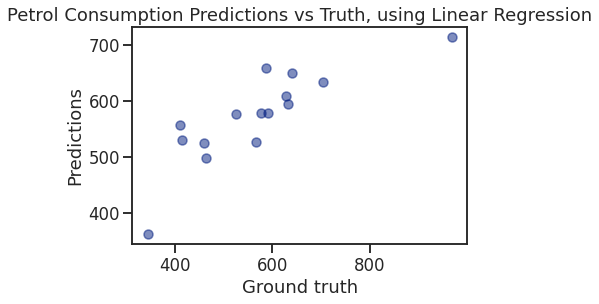

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='Ground truth', 
       ylabel='Predictions',
       title='Petrol Consumption Predictions vs Truth, using Linear Regression');

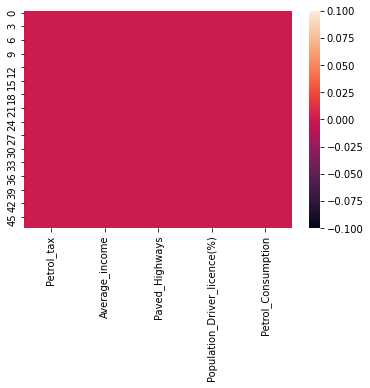

In [31]:
import seaborn as sns
sns.heatmap(dataset.isnull())

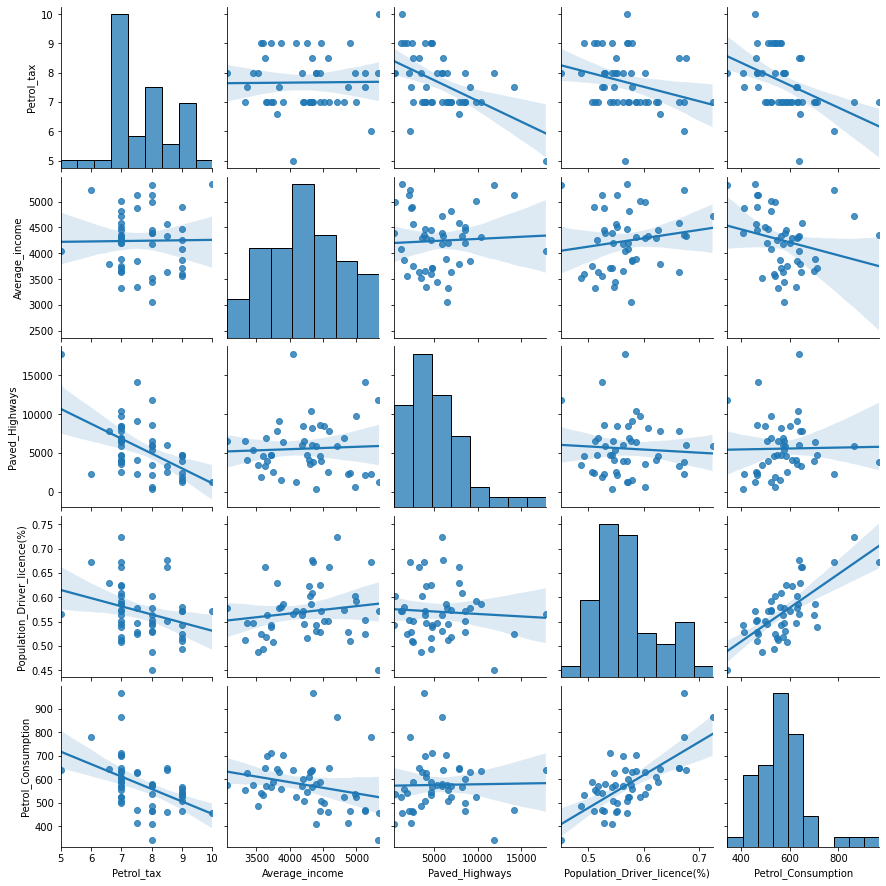

In [32]:
import seaborn as sns
sns.pairplot(dataset,kind="reg")

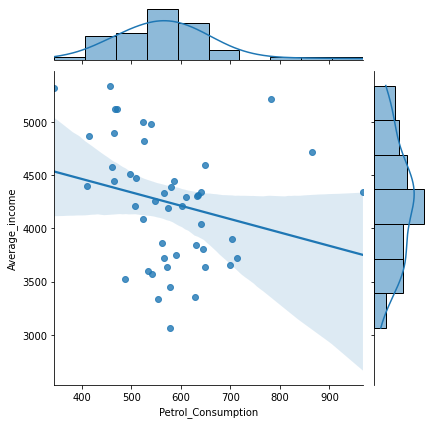

In [33]:
sns.jointplot(x="Petrol_Consumption",y="Average_income",data=dataset,kind="reg")

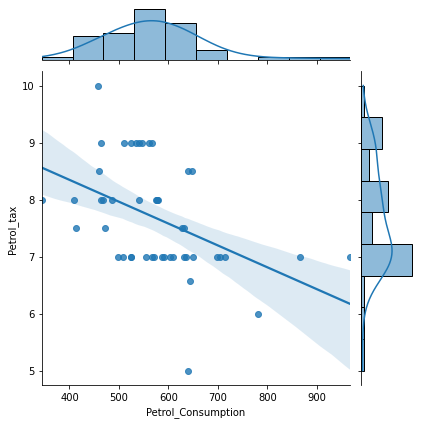

In [34]:
sns.jointplot(x="Petrol_Consumption",y="Petrol_tax",data=dataset,kind="reg")

### Linear Regression first exploration


In [35]:
## Linear Regression alternative 1
import statsmodels.api as sm
X=dataset[["Petrol_tax"]]
X[0:5]
X=sm.add_constant(X)
X[0:5]
y=dataset["Petrol_Consumption"]
lm=sm.OLS(y,X)
model=lm.fit()
model.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Petrol_Consumption   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     11.76
Date:                Sun, 27 Dec 2020   Prob (F-statistic):            0.00128
Time:                        21:46:30   Log-Likelihood:                -288.58
No. Observations:                  48   AIC:                             581.2
Df Residuals:                      46   BIC:                             584.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        984.0076    119.624      8.226      0.000     743.218    1224.797
Petrol_tax   -53.1063     15.484     -3.430      0.001     -84.273     -21.939
==============================================================================
Omnibus:                       13.679   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.100
Skew:                           0.899   Prob(JB):                     7.12e-05
Kurtosis:                       5.514   Cond. No.                         64.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
## Linear regression alternative 2
import statsmodels.formula.api as smf
lm=smf.ols("Petrol_Consumption ~ Petrol_tax",dataset)
model=lm.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Petrol_Consumption   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     11.76
Date:                Sun, 27 Dec 2020   Prob (F-statistic):            0.00128
Time:                        21:46:30   Log-Likelihood:                -288.58
No. Observations:                  48   AIC:                             581.2
Df Residuals:                      46   BIC:                             584.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    984.0076    119.624      8.226      0.000     743.218    1224.797
Petrol_tax   -53.1063     15.484     -3.430      0.001     -84.273     -21.939
==============================================================================
Omnibus:                       13.679   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.100
Skew:                           0.899   Prob(JB):                     7.12e-05
Kurtosis:                       5.514   Cond. No.                         64.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
model.params

Intercept     984.007628
Petrol_tax    -53.106298
dtype: float64

In [38]:
print(model.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    984.0076    119.624      8.226      0.000     743.218    1224.797
Petrol_tax   -53.1063     15.484     -3.430      0.001     -84.273     -21.939


In [39]:
## Confidence Interval for data's parameters
model.conf_int()

,0,1
Intercept,743.21779,1224.797465
Petrol_tax,-84.27315,-21.939446


In [40]:
## Model's f p-value
model.f_pvalue

0.0012848906734289288

In [41]:
print("f_pvalue: ","%.4f"%model.f_pvalue)

f_pvalue:  0.0013


In [42]:
print("fvalue: ","%.2f"%model.fvalue)

fvalue:  11.76


In [43]:
## T value for intercept
print("tvalue: ","%.2f"%model.tvalues[0:1])

tvalue:  8.23


In [44]:
## T value for first paramater Petrol Tax
print("tvalue: ","%.2f"%model.tvalues[1:2])

tvalue:  -3.43


In [45]:
## R squared score - representing score 
model.rsquared_adj

0.18634201474616507

In [46]:
for i in range(10):
    est=(984.6084+(-53.4869*i))
    print("{}".format(i) +". estimation: "+str(est))

0. estimation: 984.6084
1. estimation: 931.1215
2. estimation: 877.6346
3. estimation: 824.1477
4. estimation: 770.6608
5. estimation: 717.1739
6. estimation: 663.6869999999999
7. estimation: 610.2001
8. estimation: 556.7131999999999
9. estimation: 503.2263


In [47]:
## Linear Regression Model
print("Consumption of petrol = "+str("%.2f"%model.params[0])+ " + Petrol Tax "+ "* "+ str("%.2f"%model.params[1]))

Consumption of petrol = 984.01 + Petrol Tax * -53.11


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Consumption of petrol')

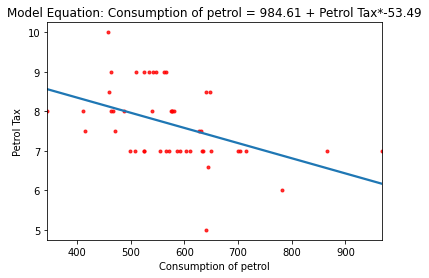

In [48]:
## Addition to all of these, you can see the details in the plot attached below. 
## There is a negative regression between Consumption of petrol and Petrol Tax...


g = sns.regplot(dataset["Petrol_Consumption"], dataset["Petrol_tax"], ci=None, scatter_kws={'color':'r', 's':9})
g.set_title("Model Equation: Consumption of petrol = 984.61 + Petrol Tax*-53.49")
g.set_ylabel("Petrol Tax")
g.set_xlabel("Consumption of petrol")

Discussion:
Suppose we want to do Linear Regression on our dataset to get an estimate, based on mean squared error, of how well our model will perform on data outside our dataset.

Suppose also that our data is split into three folds: Fold 1, Fold 2, and Fold 3.

What would the steps be, in English, to do this?

Your response below

Coding this up
The KFold object in SciKit Learn tells the cross validation object (see below) how to split up the data:

In [49]:
X = dataset.drop('Petrol_Consumption', axis=1)
y = dataset.Petrol_Consumption

In [50]:
kf = KFold(shuffle=True, random_state=72018, n_splits=3)

In [51]:
kf.split(X)

<generator object _BaseKFold.split at 0x7f9172fe2af0>

In [52]:
X.shape

(48, 4)

In [53]:
X.tail()

,Petrol_tax,Average_income,Paved_Highways,Population_Driver_licence(%)
43,7.0,3745,2611,0.508
44,6.0,5215,2302,0.672
45,9.0,4476,3942,0.571
46,7.0,4296,4083,0.623
47,7.0,5002,9794,0.593


In [54]:
for train_index, test_index in kf.split(X):
    print("Train index:", train_index[:10], len(train_index))
    print("Test index:",test_index[:10], len(test_index))
    print('')

Train index: [ 0  1  2  4  5  7  8 10 12 15] 32
Test index: [ 3  6  9 11 13 14 18 19 25 27] 16

Train index: [ 2  3  5  6  8  9 10 11 12 13] 32
Test index: [ 0  1  4  7 15 17 26 28 30 31] 16

Train index: [ 0  1  3  4  6  7  9 11 13 14] 32
Test index: [ 2  5  8 10 12 16 20 21 22 23] 16



In [55]:
#from sklearn.metrics import r2_score, mean_squared_error

scores = []
lr = LinearRegression()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    lr.fit(X_train, y_train)
        
    y_pred = lr.predict(X_test)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)
    
scores

[0.7017166726032875, 0.5408566834972458, 0.5583743341459353]

### Discussion (Part 2): 

Now suppose we want to do the same, but appropriately scaling our data as we go through the folds.

What would the steps be _now_?

In [56]:
scores = []

lr = LinearRegression()
s = StandardScaler()

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = (X.iloc[train_index, :], 
                                        X.iloc[test_index, :], 
                                        y[train_index], 
                                        y[test_index])
    
    X_train_s = s.fit_transform(X_train)
    
    lr.fit(X_train_s, y_train)
    
    X_test_s = s.transform(X_test)
    
    y_pred = lr.predict(X_test_s)

    score = r2_score(y_test.values, y_pred)
    
    scores.append(score)

In [57]:
scores

[0.7017166726032883, 0.5408566834972457, 0.5583743341459347]

(same scores, because for vanilla linear regression with no regularization, scaling actually doesn't matter for performance)

This is getting quite cumbersome! 

_Very_ luckily, SciKit Learn has some wonderful functions that handle a lot of this for us.

### `Pipeline` and `cross_val_predict`

Pipeline lets you chain together multiple operators on your data that both have a fit method.

In [58]:
s = StandardScaler()
lr = LinearRegression()

### Combine multiple processing steps into a Pipeline
A pipeline contains a series of steps, where a step is ("name of step", actual_model). The "name of step" string is only used to help you identify which step you are on, and to allow you to specify parameters at that step.

In [59]:
estimator = Pipeline([("scaler", s),
                      ("regression", lr)])

In [60]:
estimator.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [61]:
estimator.predict(X_test)

array([560.00408745, 404.30933052, 477.45432197, 487.29144751,
       564.27043016, 599.85130396, 707.60559346, 561.62671887,
       388.20749602, 436.19633625, 489.69871415, 445.61335864,
       606.70602534, 647.20695471, 731.68248338, 574.49672119])

### cross_val_predict¶
cross_val_predict is a function that does K-fold cross validation for us, appropriately fitting and transforming at every step of the way.

In [62]:
kf

KFold(n_splits=3, random_state=72018, shuffle=True)

In [63]:
predictions = cross_val_predict(estimator, X, y, cv=kf)

In [64]:
len(predictions)

48

In [65]:
r2_score(y, predictions)

0.6105004390528358

In [66]:
np.mean(scores) # almost identical!

0.6003158967488229

### Hyperparameter tuning
#### Definition
Hyperparameter tuning involves using cross validation (or train-test split) to determine which hyperparameters are most likely to generate a model that generalizes well outside of your sample.

#### Mechanics
We can generate an exponentially spaces range of values using the numpy geomspace function.

np.geomspace(1, 1000, num=4)
produces:

array([    1.,    10.,   100.,  1000.])
Use this function to generate a list of length 10 called alphas for hyperparameter tuning:

In [67]:
alphas = np.geomspace(1e-9, 1e0, num=10)
alphas

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00])

The code below tunes the alpha hyperparameter for Lasso regression.

In [68]:
scores = []
coefs = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [69]:
list(zip(alphas,scores))

[(1e-09, 0.6105004390591973),
 (1e-08, 0.6105004391164308),
 (1e-07, 0.6105004396916721),
 (1e-06, 0.6105004454507883),
 (1e-05, 0.6105005033458499),
 (0.0001, 0.6105010812886296),
 (0.001, 0.61050680053286),
 (0.01, 0.6105643511619387),
 (0.1, 0.6111318580577028),
 (1.0, 0.6158565247629548)]

In [70]:
Lasso(alpha=1e-6).fit(X, y).coef_

array([-3.47901580e+01, -6.65887451e-02, -2.42589059e-03,  1.33644896e+03])

In [71]:
Lasso(alpha=1.0).fit(X, y).coef_

array([-4.35894133e+01, -5.99092343e-02, -4.13243720e-03,  9.43357424e+02])

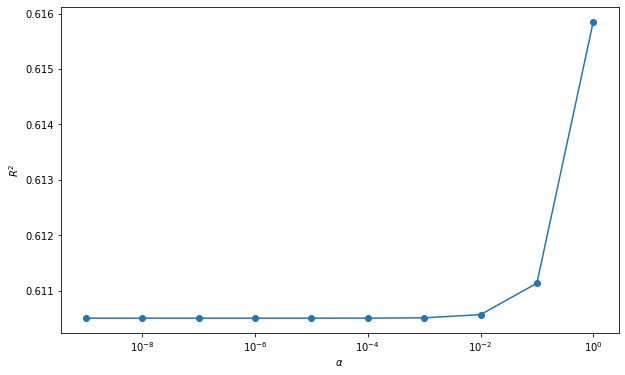

In [72]:
plt.figure(figsize=(10,6))
plt.semilogx(alphas, scores, '-o')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$');

### Exercise
Add PolynomialFeatures to this Pipeline, and re-run the cross validation with the PolynomialFeatures added.

#### Hint #1: pipelines process input from first to last. Think about the order that it would make sense to add Polynomial Features to the data in sequence and add them in the appropriate place in the pipeline.

#### Hint #2: you should see a significant increase in cross validation accuracy from doing this

In [73]:
pf = PolynomialFeatures(degree=3)

scores = []
alphas = np.geomspace(0.06, 6.0, 20)
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    
    score = r2_score(y, predictions)
    
    scores.append(score)

In [74]:
alphas

array([0.06      , 0.0764565 , 0.0974266 , 0.12414828, 0.15819905,
       0.2015891 , 0.25687994, 0.32733569, 0.41711568, 0.53152007,
       0.67730274, 0.86306993, 1.09978843, 1.40143288, 1.78581086,
       2.27561411, 2.89975814, 3.69508927, 4.70855982, 6.        ])

In [75]:
scores

[-10.033663104790428,
 -8.816117593421122,
 -8.7188858441567,
 -9.845556551530416,
 -10.461529795919867,
 -9.981663088267279,
 -10.183996288825838,
 -7.961911825405821,
 -6.235150565584016,
 -4.66783244409745,
 -3.7521517544500798,
 -3.7011303162430806,
 -3.6941106479082144,
 -3.470123467207258,
 -3.207002817328049,
 -2.822445243640689,
 -2.489793556541159,
 -2.1937391298981264,
 -1.9626169144545718,
 -1.6654884877767855]

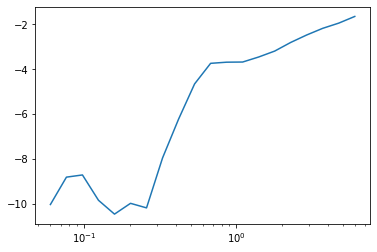

In [76]:
plt.semilogx(alphas, scores);

In [77]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.7996648724875631

In [78]:
best_estimator.named_steps["lasso_regression"].coef_

array([  0.        , -25.39177543, -54.49590474,  -5.72327172,
        70.58708746,   8.74648122,  26.41648306,  15.27794607,
       -30.63655538, -14.81371958,   9.02861099,  18.71406467,
         5.30092588, -23.59501191,   4.85586125])

### Exercise
Do the same, but with Ridge regression

Which model, Ridge or Lasso, performs best with its optimal hyperparameters on the dataset?

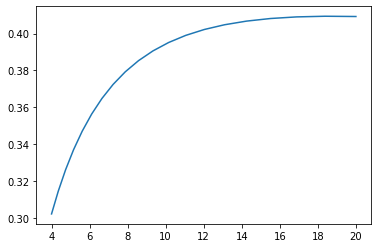

In [79]:
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions = cross_val_predict(estimator, X, y, cv = kf)
    score = r2_score(y, predictions)
    scores.append(score)

plt.plot(alphas, scores)

**Conclusion:** Both Lasso and Ridge with proper hyperparameter tuning give better results than plain ol' Linear Regression!

**Exercise:**
Now, for whatever your best overall hyperparameter was:

Standardize the data

Fit and predict on the entire dataset

See what the largest coefficients were

Hint: use

dict(zip(model.coef_, pf.get_feature_names()))
for your model model to get the feature names from PolynomialFeatures.

Then, use

dict(zip(list(range(len(X.columns.values))), X.columns.values))
to see which features in the PolynomialFeatures DataFrame correspond to which columns in the original DataFrame.

In [80]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("make_higher_degree", PolynomialFeatures(degree=2, include_bias=False)),
                    ("scaler", s),
                    ("lasso_regression", Lasso(alpha=0.01))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 47623.69057613884, tolerance: 58.836647916666664
  positive)


0.7986990072322395

In [81]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [82]:
# Once we have found the hyperparameter (alpha~1e-2=0.01)
# make the model and train it on ALL the data
# Then release it into the wild .....
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(X, y)
best_estimator.score(X, y)

0.7996648724875631

In [83]:
df_importances = pd.DataFrame(zip(best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns),
                 best_estimator.named_steps["lasso_regression"].coef_,
))

In [84]:
df_importances.sort_values(by=1)

,0,1
2,Average_income,-54.495905
8,Petrol_tax Population_Driver_licence(%),-30.636555
1,Petrol_tax,-25.391775
13,Paved_Highways Population_Driver_licence(%),-23.595012
9,Average_income^2,-14.813720
3,Paved_Highways,-5.723272
0,1,0.000000
14,Population_Driver_licence(%)^2,4.855861
12,Paved_Highways^2,5.300926
5,Petrol_tax^2,8.746481


In [85]:
col_names_dict = dict(zip(list(range(len(X.columns.values))), X.columns.values))

In [86]:
col_names_dict

{0: 'Petrol_tax',
 1: 'Average_income',
 2: 'Paved_Highways',
 3: 'Population_Driver_licence(%)'}

In [87]:
df_importances.sort_values(by=1)

,0,1
2,Average_income,-54.495905
8,Petrol_tax Population_Driver_licence(%),-30.636555
1,Petrol_tax,-25.391775
13,Paved_Highways Population_Driver_licence(%),-23.595012
9,Average_income^2,-14.813720
3,Paved_Highways,-5.723272
0,1,0.000000
14,Population_Driver_licence(%)^2,4.855861
12,Paved_Highways^2,5.300926
5,Petrol_tax^2,8.746481


In [88]:
best_estimator.named_steps["make_higher_degree"].get_feature_names(input_features=X.columns)

['1',
 'Petrol_tax',
 'Average_income',
 'Paved_Highways',
 'Population_Driver_licence(%)',
 'Petrol_tax^2',
 'Petrol_tax Average_income',
 'Petrol_tax Paved_Highways',
 'Petrol_tax Population_Driver_licence(%)',
 'Average_income^2',
 'Average_income Paved_Highways',
 'Average_income Population_Driver_licence(%)',
 'Paved_Highways^2',
 'Paved_Highways Population_Driver_licence(%)',
 'Population_Driver_licence(%)^2']

In [89]:
 best_estimator.named_steps["lasso_regression"].coef_

array([  0.        , -25.39177543, -54.49590474,  -5.72327172,
        70.58708746,   8.74648122,  26.41648306,  15.27794607,
       -30.63655538, -14.81371958,   9.02861099,  18.71406467,
         5.30092588, -23.59501191,   4.85586125])

### Grid Search CV
To do cross-validation, we used two techniques:

* use KFolds and manually create a loop to do cross-validation
* use cross_val_predict and score to get a cross-valiated score in a couple of lines.
To do hyper-parameter tuning, we see a general pattern:

* use cross_val_predict and score in a manually written loop over hyperparemeters, then select the best one.
Perhaps not surprisingly, there is a function that does this for us -- GridSearchCV

In [90]:
from sklearn.model_selection import GridSearchCV

# Same estimator as before
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

grid = GridSearchCV(estimator, params, cv=kf)

In [91]:
grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=72018, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('polynomial_features',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('ridge_regression',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercep...
        5.27924796,  5.58051751,  5.8989

In [92]:
grid.best_score_, grid.best_params_

(0.6370529481159518,
 {'polynomial_features__degree': 1,
  'ridge_regression__alpha': 5.58051750774668})

In [93]:
y_predict = grid.predict(X)

In [94]:
# This includes both in-sample and out-of-sample
r2_score(y, y_predict)

0.6716764507971167

In [95]:
# Notice that "grid" is a fit object!
# We can use grid.predict(X_test) to get brand new predictions!
grid.best_estimator_.named_steps['ridge_regression'].coef_

array([  0.        , -30.89689686, -32.83045687,  -7.32204101,
        65.55194851])

In [96]:
grid.cv_results_

{'mean_fit_time': array([0.00651487, 0.00434089, 0.0040439 , 0.00346812, 0.00299748,
        0.00296823, 0.00292675, 0.00284123, 0.00286746, 0.00292142,
        0.00290235, 0.00298524, 0.00286301, 0.00286587, 0.00287056,
        0.00281962, 0.00284171, 0.00295377, 0.00285045, 0.00302092,
        0.00301576, 0.002906  , 0.00326633, 0.00288701, 0.00304747,
        0.00285999, 0.00285602, 0.00326331, 0.00337052, 0.00308291,
        0.00303006, 0.00301154, 0.00305971, 0.00296434, 0.0029877 ,
        0.00291451, 0.00300535, 0.00310135, 0.00316556, 0.00341344,
        0.00310524, 0.003028  , 0.00309952, 0.00310612, 0.00330003,
        0.00556072, 0.00391324, 0.00316993, 0.00320355, 0.00307266,
        0.00319433, 0.00309904, 0.00327349, 0.00302521, 0.00302966,
        0.00311963, 0.00304198, 0.0030334 , 0.00312988, 0.00302784,
        0.00323145, 0.00310755, 0.00324289, 0.00359805, 0.00389536,
        0.00326188, 0.00313393, 0.00316238, 0.00307425, 0.00320824,
        0.00314212, 0.00322024,

In [97]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_polynomial_features__degree,param_ridge_regression__alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006515,0.003206,0.003040,0.001195,1,4,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754664,0.506357,0.644840,0.635287,0.101596,11
1,0.004341,0.001365,0.001823,0.000273,1,4.22827,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754752,0.504471,0.648213,0.635812,0.102552,9
2,0.004044,0.000764,0.001677,0.000187,1,4.46956,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754656,0.502487,0.651632,0.636259,0.103520,8
3,0.003468,0.000045,0.001513,0.000102,1,4.72462,"{'polynomial_features__degree': 1, 'ridge_regr...",0.754361,0.500402,0.655087,0.636617,0.104498,6
4,0.002997,0.000070,0.001384,0.000110,1,4.99424,"{'polynomial_features__degree': 1, 'ridge_regr...",0.753849,0.498210,0.658568,0.636876,0.105485,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.003102,0.000069,0.001500,0.000026,3,16.0184,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.387809,0.436739,0.467324,-1.494582,2.752956,65
86,0.003075,0.000057,0.001508,0.000007,3,16.9326,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.259179,0.432275,0.455113,-1.457264,2.688376,64
87,0.003162,0.000101,0.001483,0.000024,3,17.8989,"{'polynomial_features__degree': 3, 'ridge_regr...",-5.127540,0.427860,0.443804,-1.418625,2.622607,63
88,0.003065,0.000039,0.001543,0.000073,3,18.9203,"{'polynomial_features__degree': 3, 'ridge_regr...",-4.993132,0.423497,0.433477,-1.378719,2.555779,62


### Lasso with and without scaling
We discussed Lasso in lecture.

Let's review together:

What is different about Lasso vs. regular Linear Regression?
Is standardization more or less important with Lasso vs. Linear Regression? Why?

In [98]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

## Create polynomial features
PolynomialFeatures

In [99]:
pf = PolynomialFeatures(degree=2, include_bias=False,)
X_pf = pf.fit_transform(X)

**Note:** We use include_bias=False since Lasso includes a bias by default.

In [100]:
X_pf_ss = s.fit_transform(X_pf)

## Lasso
Lasso documentation

In [101]:
las = Lasso()
las.fit(X_pf_ss, y)
las.coef_ 

array([  0.        , -17.64314015,  -0.        ,   0.        ,
         4.92812486,  -0.        ,   0.        , -41.20456677,
       -20.74293952,  -0.        ,   0.        ,  -3.29161187,
        -5.63225979, 103.18561845])

## Exercise
Compare

* Sum of magnitudes of the coefficients
* Number of coefficients that are zero
for Lasso with alpha 0.1 vs. 1.

Before doing the exercise, answer the following questions in one sentence each:

* Which do you expect to have greater magnitude?
* Which do you expect to have more zeros?

In [102]:
las01 = Lasso(alpha = 0.1)
las01.fit(X_pf_ss, y)
print('sum of coefficients:', abs(las01.coef_).sum() )
print('number of coefficients not equal to 0:', (las01.coef_!=0).sum())

sum of coefficients: 1680.296532559976
number of coefficients not equal to 0: 14


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10014.054421865992, tolerance: 58.836647916666664
  positive)


In [103]:
las1 = Lasso(alpha = 1)
las1.fit(X_pf_ss, y)
print('sum of coefficients:',abs(las1.coef_).sum() )
print('number of coefficients not equal to 0:',(las1.coef_!=0).sum())

sum of coefficients: 196.62826141518
number of coefficients not equal to 0: 7


With more regularization (higher alpha) we will expect the penalty for higher weights to be greater and thus the coefficients to be pushed down. Thus a higher alpha means lower magnitude with more coefficients pushed down to 0.

## Exercise:  𝑅2 
Calculate the  𝑅2  of each model without train/test split.

Recall that we import  𝑅2  using:

from sklearn.metrics import r2_score

In [104]:
from sklearn.metrics import r2_score
r2_score(y,las.predict(X_pf_ss))

0.7093600182448968

#### Discuss:
Will regularization ever increase model performance if we evaluate on the same dataset that we trained on?

## With train/test split
Discuss
Are there any issues with what we've done so far?

Hint: Think about the way we have done feature scaling.

Discuss in groups of two or three.

In [105]:
from sklearn.model_selection import train_test_split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
                                                    random_state=72018)

In [107]:
X_train_s = s.fit_transform(X_train)
las.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred = las.predict(X_test_s)
r2_score(y_pred, y_test)

0.4609769497766186

In [108]:
X_train_s = s.fit_transform(X_train)
las01.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred = las01.predict(X_test_s)
r2_score(y_pred, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14443.304354670407, tolerance: 37.11060606060606
  positive)


0.19446723255352427

### Exercise
#### Part 1:
Do the same thing with Lasso of:

alpha of 0.001
Increase max_iter to 100000 to ensure convergence.
Calculate the  𝑅2  of the model.

Feel free to copy-paste code from above, but write a one sentence comment above each line of code explaining why you're doing what you're doing.

#### Part 2:
Do the same procedure as before, but with Linear Regression.

Calculate the  𝑅2  of this model.

#### Part 3:
Compare the sums of the absolute values of the coefficients for both models, as well as the number of coefficients that are zero. Based on these measures, which model is a "simpler" description of the relationship between the features and the target?

In [109]:
# Part 1

# Decreasing regularization and ensuring convergence
las001 = Lasso(alpha = 0.001, max_iter=100000)

# Transforming training set to get standardized units
X_train_s = s.fit_transform(X_train)

# Fitting model to training set
las001.fit(X_train_s, y_train)

# Transforming test set using the parameters defined from training set
X_test_s = s.transform(X_test)

# Finding prediction on test set
y_pred = las001.predict(X_test_s)

# Calculating r2 score
print("r2 score for alpha = 0.001:", r2_score(y_pred, y_test))


# Part 2

# Using vanilla Linear Regression
lr = LinearRegression()

# Fitting model to training set
lr.fit(X_train_s, y_train)

# predicting on test set
y_pred_lr = lr.predict(X_test_s)

# Calculating r2 score
print("r2 score for Linear Regression:", r2_score(y_pred_lr, y_test))


# Part 3
print('Magnitude of Lasso coefficients:', abs(las001.coef_).sum())
print('Number of coeffients not equal to 0 for Lasso:', (las001.coef_!=0).sum())

print('Magnitude of Linear Regression coefficients:', abs(lr.coef_).sum())
print('Number of coeffients not equal to 0 for Linear Regression:', (lr.coef_!=0).sum())

r2 score for alpha = 0.001: -0.5002390690094176
r2 score for Linear Regression: -0.5057452957820394
Magnitude of Lasso coefficients: 2846.7631898942163
Number of coeffients not equal to 0 for Lasso: 14
Magnitude of Linear Regression coefficients: 2884.974684303446
Number of coeffients not equal to 0 for Linear Regression: 14


### L1 vs. L2 Regularization
As mentioned in the deck: Lasso and Ridge regression have the same syntax in SciKit Learn.

Now we're going to compare the results from Ridge vs. Lasso regression:

Ridge

In [110]:
from sklearn.linear_model import Ridge

### Exercise
Following the Ridge documentation from above:

1. Define a Ridge object r with the same alpha as las001.
2. Fit that object on X and y and print out the resulting coefficients.

In [111]:
r = Ridge(alpha = 0.001)
X_train_s = s.fit_transform(X_train)
r.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred_r = r.predict(X_test_s)

# Calculating r2 score
r.coef_

array([  -9.3679424 ,   18.03085649,  411.94093985, -171.04496261,
         77.57747323,  135.97430869,  -18.40180212, -149.55365378,
         60.56000832,  131.21960254, -343.63493358,  -30.72697267,
       -504.17653575,  598.17096961])

In [112]:
las001 # same alpha as Ridge above

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [113]:
las001.coef_

array([ -10.32198084,   42.89950165,  445.39851412, -206.09500118,
         76.33743329,  122.61459552,  -30.64699829, -138.06071389,
         69.25257543,  130.60571358, -377.16110261,  -31.92112376,
       -522.90055619,  642.54737955])

In [114]:
print(np.sum(np.abs(r.coef_)))
print(np.sum(np.abs(las001.coef_)))

print(np.sum(r.coef_ != 0))
print(np.sum(las001.coef_ != 0))

2660.3809616393246
2846.7631898942163
14
14


**Conclusion**: Ridge does not make any coefficients 0. In addition, on this particular dataset, Lasso provides stronger overall regularization than Ridge for this value of alpha (not necessarily true in general).

In [115]:
y_pred = r.predict(X_pf_ss)
print(r2_score(y, y_pred))

y_pred = las001.predict(X_pf_ss)
print(r2_score(y, y_pred))

-0.05669364636345975
-0.11067691671508317


# Example: Does it matter when you scale?

In [116]:
from sklearn.preprocessing import StandardScaler

In [117]:
s = StandardScaler()
X_ss = s.fit_transform(X)

In [118]:
lr2 = LinearRegression()
lr2.fit(X_ss, y)
print(lr2.coef_) # coefficients now "on the same scale"

[-32.7310515  -37.79691223  -8.3813148   73.3569154 ]


In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y, test_size=0.3, 
                                                    random_state=72018)

In [120]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
r2_score(y_pred, y_test)

0.75392809099585

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=72018)

In [122]:
s = StandardScaler()
lr_s = LinearRegression()
X_train_s = s.fit_transform(X_train)
lr_s.fit(X_train_s, y_train)
X_test_s = s.transform(X_test)
y_pred_s = lr_s.predict(X_test_s)
r2_score(y_pred_s, y_test)

0.7539280909958498

In [123]:
X = dataset[['Petrol_tax', 'Average_income', 'Paved_Highways',
       'Population_Driver_licence(%)']]
y = dataset['Petrol_Consumption']

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Training the Algorithm
And finally, to train the algorithm we execute the same code as before, using the fit() method of the LinearRegression class:

In [125]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

As said earlier, in case of multivariable linear regression, the regression model has to find the most optimal coefficients for all the attributes. To see what coefficients our regression model has chosen, execute the following script:

In [126]:
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])
coeff_df

,Coefficient
Petrol_tax,-40.016660
Average_income,-0.065413
Paved_Highways,-0.004741
Population_Driver_licence(%),1341.862121


This means that for a unit increase in "petrol_tax", there is a decrease of 24.19 million gallons in gas consumption. Similarly, a unit increase in proportion of population with a drivers license results in an increase of 1.324 billion gallons of gas consumption. We can see that "Average_income" and "Paved_Highways" have a very little effect on the gas consumption.

### Making Predictions
To make pre-dictions on the test data, execute the following script:

In [127]:
y_pred = regressor.predict(X_test)

To compare the actual output values for X_test with the predicted values, execute the following script:

In [128]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
29,534,469.391989
4,410,545.645464
26,577,589.668394
30,571,569.730413
32,577,649.774809
37,704,646.631164
34,487,511.608148
40,587,672.475177
7,467,502.074782
10,580,501.270734


### Evaluating the Algorithm
The final step is to evaluate the performance of algorithm. We'll do this by finding the values for MAE, MSE and RMSE. Execute the following script:

In [129]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 56.8222474789647
Mean Squared Error: 4666.344787588362
Root Mean Squared Error: 68.31064915215168


You can see that the value of root mean squared error is 60.07, which is slightly greater than 10% of the mean value of the gas consumption in all states. This means that our algorithm was not very accurate but can still make reasonably good predictions.

There are many factors that may have contributed to this inaccuracy, a few of which are listed here:

1. Need more data: Only one year worth of data isn't that much, whereas having multiple years worth could have helped us improve the accuracy quite a bit.
2. Bad assumptions: We made the assumption that this data has a linear relationship, but that might not be the case. Visualizing the data may help you determine that.
3. Poor features: The features we used may not have had a high enough correlation to the values we were trying to predict.